# Análise de músicas: Tyler, The Creator

O objetivo desse notebook é, justamente, analisar as músicas do artista "Tyler, The Creator", responsável por álbuns fantásticos como "CHROMAKOPIA", "CALL ME IF YOU GET LOST", "IGOR", "Wolf", dentre outros.

Para isso, usaremos árvores de decisão, mais especificamente o modelo *Random Forest* aplicado a problemas de regressão. Antes de mais nada, vamos entender o que é esse modelo e o que são problemas de regressão.

## *Random Forest*

O *Random Forest Regressor* (modelo de aprendizado que utilizaremos, já implementado na biblioteca *scikit-learn*) é um algoritmo supervisionado que **combina múltiplas árvores de decisão para prever um valor numérico (variável contínua**). A previsão final é a **média das previsões de cada árvore**, o que ajuda a reduzir o *overfitting* (modelo se ajustar excessivamente aos dados apresentados e errar ao se deparar com dados novos) e a melhorar a generalização do modelo. Ele é útil para problemas de regressão, como prever a popularidade de uma música, baseado em suas características, que será o que abordaremos nesse notebook.

## Problemas de Regressão

Problemas de regressão são problemas de aprendizado de máquina em que o objetivo é prever um valor numérico contínuo. Em um problema de regressão, a variável alvo (ou *target*) pode assumir qualquer valor em um intervalo contínuo, como preço, peso, temperatura, tempo, ou pontuações. Um exemplo famoso desse tipo de problema é o de prever valores de aluguel de determinado imóvel com base em suas características.

Nossa tarefa principal em problemas de regressão é encontrar uma relação entre as variáveis de entrada (*features*) e a variável alvo para estimar valores novos ou futuros, tudo isso usando aprendizagem de máquina (ou aprendizagem profunda).

## Vamos aos dados...
Dito isso, vamos trabalhar com os dados do artista, catalogados com o auxílio da API pública do Spotify.

### Importando bibliotecas e dados...

Para essa tarefa, usaremos bibliotecas como o pandas, numpy, scikit-learn, etc. Portanto, faremos a importação dessas todas logo de início. Faço isso por preferência pessoal, visto que poderia importá-las conforme necessário nas células a seguir.

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tyler_the_creator_dataset_path = kagglehub.dataset_download('chik0di/tyler-the-creator-dataset')
df = pd.read_csv(tyler_the_creator_dataset_path + '/Tyler The Creator Dataset.csv') # Criando um dataset com o arquivo CSV

df.head()

,artist_name,track_name,track_id,album_name,album_id,release_date,popularity,explicit,danceability,energy,...,liveness,valence,tempo,time_signature,featured_artists,type,duration,year,month,day_of_the_week
0,"Tyler, The Creator",EARFQUAKE,5hVghJ4KaYES3BFUATCYn0,IGOR,5zi7WsKlIiUXv09tbGLKsE,2019-05-17,80,True,0.554,0.498,...,0.795,0.413,79.635,4,NaN,Studio Album,03:10,2019,May,Friday
1,"Tyler, The Creator",See You Again (feat. Kali Uchis),7KA4W4McWYRpgf0fWsJZWB,Flower Boy,2nkto6YNI4rUYTLqEwWJ3o,2017-07-21,89,True,0.558,0.559,...,0.109,0.620,78.558,4,Kali Uchis,Studio Album,03:00,2017,July,Friday
2,"Tyler, The Creator",Noid,1tnZxHryc2wWtjUZC1LQw5,Noid,4OjzAZXWalqQN5STXHPJdl,2024-10-21,69,True,0.380,0.770,...,0.243,0.470,82.157,4,NaN,Single,04:47,2024,October,Monday
3,"Tyler, The Creator",BEST INTEREST,3jHdKaLCkuNEkWcLVmQPCX,BEST INTEREST,5iUwaD3wFVwfaAfs9Z0eCh,2020-01-25,81,True,0.596,0.575,...,0.334,0.340,98.265,3,NaN,Single,02:07,2020,January,Saturday
4,"Tyler, The Creator",ARE WE STILL FRIENDS?,5TxRUOsGeWeRl3xOML59Ai,IGOR,5zi7WsKlIiUXv09tbGLKsE,2019-05-17,79,True,0.216,0.497,...,0.111,0.313,187.308,3,NaN,Studio Album,04:25,2019,May,Friday


### Pré-processamento dos dados

Agora começaremos o processo de limpeza e entendimento dos dados. Para essa tarefa, pretendo alcançar os seguintes objetivos:

- Identificar variáveis (*features*) desnecessárias e/ou redundantes e retirá-las do *dataset*.
- Manipular o *dataset* conforme meu objetivo final, que será analisar apenas músicas do próprio Tyler (não levaremos em conta músicas que ele apenas participou).
- Codificação de variáveis categóricas, visto que o modelo que utilizaremos não consegue lidar com *strings* diretamente.
- Generalizar os atributos que pudermos, como será o caso de *featured_artists*.

In [2]:
df = df[df['artist_name'] == 'Tyler, The Creator'] # Mantendo apenas músicas do próprio Tyler
df = df.drop(columns=['artist_name', 'track_id', 'album_id', 'release_date'])
df['duration'] = df['duration'].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1])) # Transformando de minutos:segundos p/ segundos

df.head()

,track_name,album_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,time_signature,featured_artists,type,duration,year,month,day_of_the_week
0,EARFQUAKE,IGOR,80,True,0.554,0.498,A,-8.866,Major,0.0685,...,0.795,0.413,79.635,4,NaN,Studio Album,190,2019,May,Friday
1,See You Again (feat. Kali Uchis),Flower Boy,89,True,0.558,0.559,F#/Gb,-9.222,Major,0.0959,...,0.109,0.620,78.558,4,Kali Uchis,Studio Album,180,2017,July,Friday
2,Noid,Noid,69,True,0.380,0.770,C#/Db,-5.993,Major,0.2420,...,0.243,0.470,82.157,4,NaN,Single,287,2024,October,Monday
3,BEST INTEREST,BEST INTEREST,81,True,0.596,0.575,B,-8.325,Minor,0.0514,...,0.334,0.340,98.265,3,NaN,Single,127,2020,January,Saturday
4,ARE WE STILL FRIENDS?,IGOR,79,True,0.216,0.497,A#/Bb,-8.025,Major,0.0371,...,0.111,0.313,187.308,3,NaN,Studio Album,265,2019,May,Friday


In [3]:
df['hasFeaturedArtists'] = df['featured_artists'].notna()
df = df.drop(columns = ['featured_artists'])

df.head()

,track_name,album_name,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,time_signature,type,duration,year,month,day_of_the_week,hasFeaturedArtists
0,EARFQUAKE,IGOR,80,True,0.554,0.498,A,-8.866,Major,0.0685,...,0.795,0.413,79.635,4,Studio Album,190,2019,May,Friday,False
1,See You Again (feat. Kali Uchis),Flower Boy,89,True,0.558,0.559,F#/Gb,-9.222,Major,0.0959,...,0.109,0.620,78.558,4,Studio Album,180,2017,July,Friday,True
2,Noid,Noid,69,True,0.380,0.770,C#/Db,-5.993,Major,0.2420,...,0.243,0.470,82.157,4,Single,287,2024,October,Monday,False
3,BEST INTEREST,BEST INTEREST,81,True,0.596,0.575,B,-8.325,Minor,0.0514,...,0.334,0.340,98.265,3,Single,127,2020,January,Saturday,False
4,ARE WE STILL FRIENDS?,IGOR,79,True,0.216,0.497,A#/Bb,-8.025,Major,0.0371,...,0.111,0.313,187.308,3,Studio Album,265,2019,May,Friday,False


In [4]:
df['explicit'] = df['explicit'].astype(int) # Converção booleano para int (0/1)
df['hasFeaturedArtists'] = df['hasFeaturedArtists'].astype(int) # Converção booleano para int (0/1)
df = pd.get_dummies(df, columns=['track_name', 'album_name', 'key', 'mode', 'type', 'month', 'day_of_the_week']) # One-Hot Encoding

df.head()

,popularity,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,month_June,month_March,month_May,month_November,month_October,day_of_the_week_Friday,day_of_the_week_Monday,day_of_the_week_Saturday,day_of_the_week_Tuesday,day_of_the_week_Wednesday
0,80,1,0.554,0.498,-8.866,0.0685,0.2300,0.000006,0.795,0.413,...,False,False,True,False,False,True,False,False,False,False
1,89,1,0.558,0.559,-9.222,0.0959,0.3710,0.000007,0.109,0.620,...,False,False,False,False,False,True,False,False,False,False
2,69,1,0.380,0.770,-5.993,0.2420,0.4730,0.000151,0.243,0.470,...,False,False,False,False,True,False,True,False,False,False
3,81,1,0.596,0.575,-8.325,0.0514,0.0861,0.000153,0.334,0.340,...,False,False,False,False,False,False,False,True,False,False
4,79,1,0.216,0.497,-8.025,0.0371,0.1280,0.000002,0.111,0.313,...,False,False,True,False,False,True,False,False,False,False


### Configuração e execução do modelo preditivo

Agora vamos, enfim, utilizar os dados já organizados para o treinamento de nosso modelo.

In [5]:
X = df.drop(columns = ['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### Avaliação do modelo

Para o avaliarmos, usaremos algumas métricas importantes para dizer sua efetividade na predição.

#### 1. Mean Absolute Error (MAE)
O ***Mean Absolute Error* (MAE)** é a **média das diferenças absolutas entre os valores reais e as previsões do modelo**. É uma métrica intuitiva que **mede a magnitude média do erro** em um conjunto de previsões, sem considerar sua direção. Um MAE menor indica um modelo mais preciso.

#### 2. Mean Squared Error (MSE)
O ***Mean Squared Error* (MSE)** é a **média das diferenças quadráticas entre os valores reais e as previsões**. Ao elevar ao quadrado os erros, o **MSE penaliza mais os erros maiores**, tornando-o **sensível a *outliers***. Um MSE menor sugere que o modelo faz previsões mais precisas.

#### 3. R² Score (Coeficiente de Determinação)
O **R² *Score*** mede a **proporção da variabilidade nos dados** que é explicada pelo modelo. Os valores variam de 0 a 1, onde 1 indica que o modelo explica 100% da variabilidade dos dados. Um R² mais próximo de 1 indica um melhor ajuste do modelo aos dados.

#### 4. Root Mean Squared Error (RMSE)

O **Root Mean Squared Error (RMSE)** é uma métrica utilizada para avaliar a precisão de um modelo de regressão. Ele representa a raiz quadrada do **Mean Squared Error (MSE)**.

##### Interpretação do RMSE
- O RMSE fornece uma medida do erro de previsão na mesma unidade da variável dependente, facilitando a interpretação.
- Um RMSE de 0 indica previsões perfeitas, enquanto valores mais altos indicam um desempenho pior do modelo.
- É sensível a outliers, pois penaliza mais os erros maiores.

##### Comparação com Outras Métricas
- O RMSE é frequentemente utilizado junto com o **Mean Absolute Error (MAE)** e o **Mean Squared Error (MSE)** para fornecer uma visão mais completa do desempenho do modelo.
- Um RMSE menor indica um modelo que faz previsões mais precisas.


In [6]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error: 5.98
Mean Squared Error: 61.18
R^2 Score: 0.75
Root Mean Squared Error (RMSE): 7.82


### Análise da Importância das Características em Random Forest

#### Objetivo
Este código tem como objetivo visualizar a importância das características em um modelo de Random Forest após o uso de *one-hot encoding*.

#### Passos do Código
  
1. **Obter Importância das Características**: Usa `model.feature_importances_` para extrair a importância de cada atributo no modelo de Random Forest.

2. **Criar um DataFrame**: Um DataFrame é criado com duas colunas: `feature` (nome das características) e `importance` (valores de importância).

3. **Agrupamento por Variável Original**:
   - A coluna `original_feature` é criada para armazenar o nome original da característica, mantendo a parte anterior ao sublinhado (`_`).
   - O DataFrame é então agrupado pela coluna `original_feature`, somando as importâncias associadas a cada variável original.

4. **Ordenação**: O DataFrame agrupado é ordenado em ordem decrescente com base nos valores de importância.

5. **"Plotar" a Importância das Características**: Um gráfico de barras é criado para mostrar a importância das variáveis originais, facilitando a leitura e interpretação.

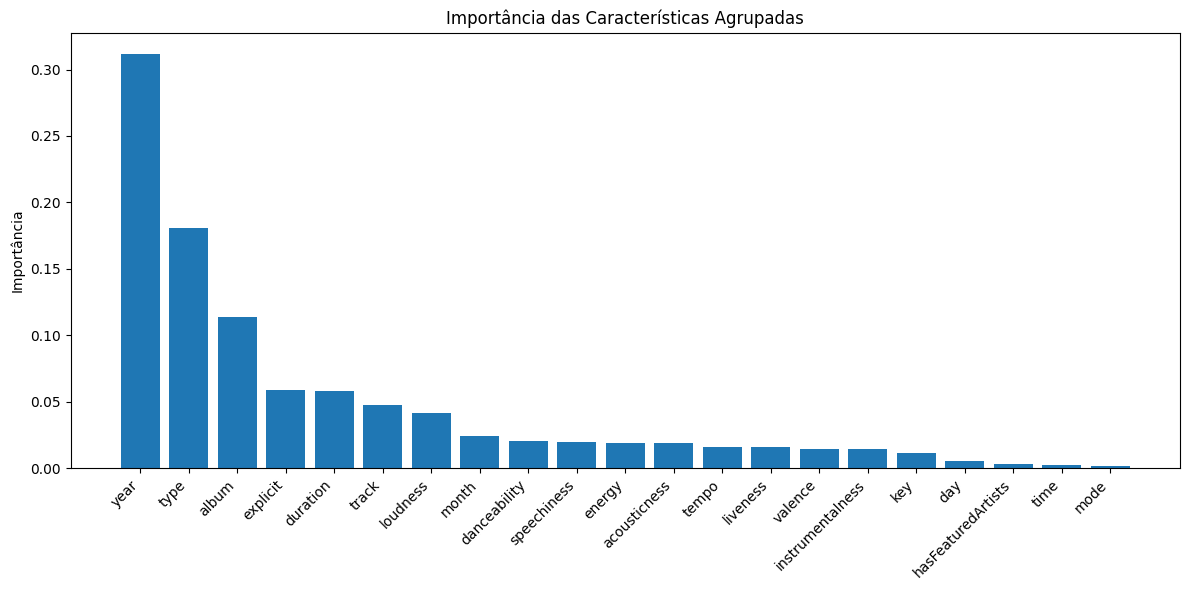

In [7]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

importance_df['original_feature'] = importance_df['feature'].apply(lambda x: x.split('_')[0])
grouped_importance = importance_df.groupby('original_feature')['importance'].sum().reset_index()

grouped_importance = grouped_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.title("Importância das Características Agrupadas")
plt.bar(grouped_importance['original_feature'], grouped_importance['importance'], align='center')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importância")
plt.tight_layout()
plt.show()